In [1]:
import keras
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) # Expanding Dimension as (image_row, image_column, channel)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)    # to be compatible for tensorflow backend

x_train /= 255  # Getting input in range (0,1) to avoid instablity.
x_test /= 255

input_shape = (28, 28, 1)
num_classes = 10
batch_size = 100

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def plot_history(history, name):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(name+' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(name+' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()
    print('Train accuracy:', history.history['acc'][-1])
    print('Test accuracy:', history.history['val_acc'][-1])

#### Linear model (Logistic regression) or only sigmoid activation at last layer.

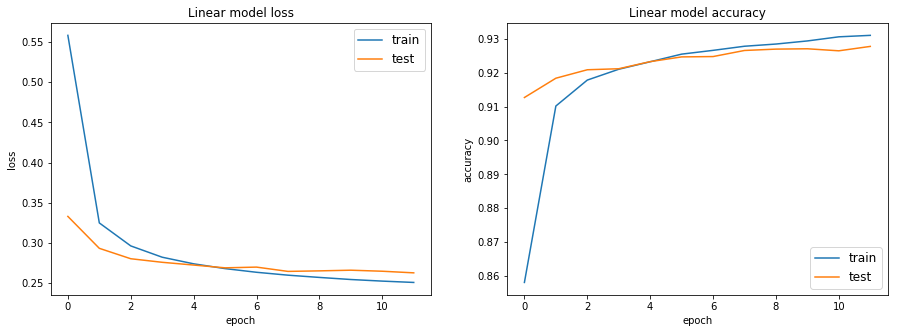

Train accuracy: 0.931066666667
Test accuracy: 0.9278


In [5]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64 , verbose=0)
plot_history(history,'Linear')

#### Only densely connected layers

##### Single layer of 128 hidden units.

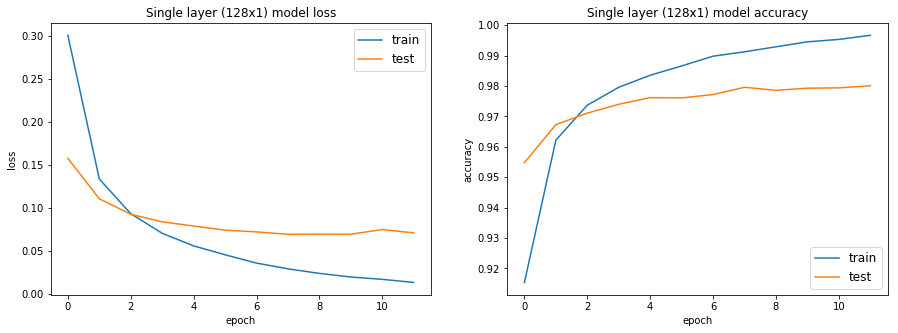

Train accuracy: 0.996683333333
Test accuracy: 0.9801


In [6]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64 , verbose=0)
plot_history(history,'Single layer (128x1)')

Clearly the above model is overfitting since there is wide gap in training and test accuracy.

#### Single layer of 256 hidden units.

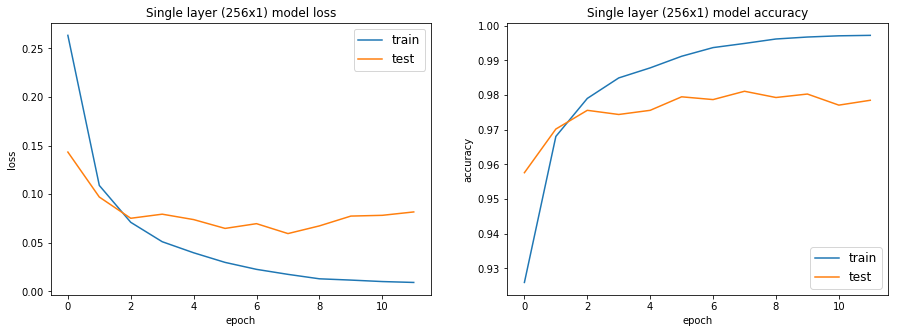

Train accuracy: 0.997233333333
Test accuracy: 0.9785


In [7]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64 , verbose=0)
plot_history(history,'Single layer (256x1)')

Lets us use 256 hidden units and droput to address overfitting. 

##### Dropout = 0.2

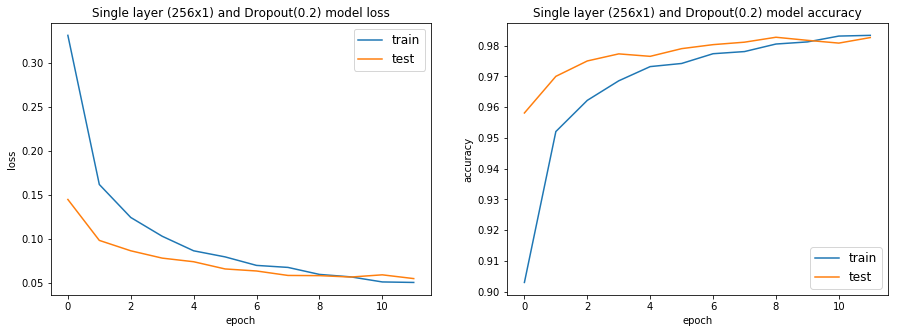

Train accuracy: 0.983316666667
Test accuracy: 0.9826


In [8]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64 , verbose=0)
plot_history(history,'Single layer (256x1) and Dropout(0.2)')

Seems better now, model isn't overfitting but we haven't reached 99% accuracy yet. Next we will try out convulation network.

##### Dropout = 0.5

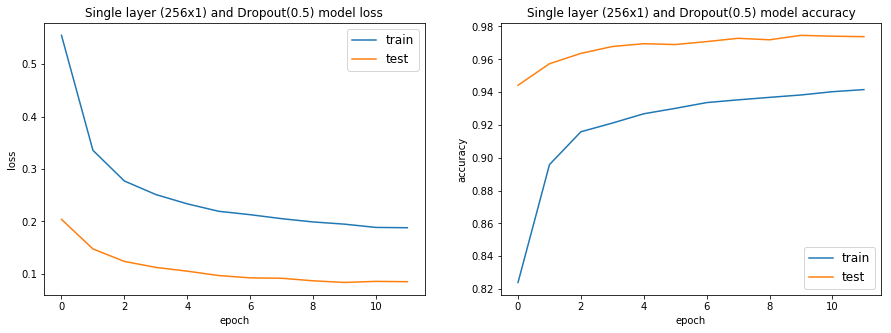

Train accuracy: 0.941533333333
Test accuracy: 0.9738


In [9]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=12, batch_size=64 , verbose=0)
plot_history(history,'Single layer (256x1) and Dropout(0.5)')

Increasing dropout seems to worsen the case and model now underfits. We will stick with 0.2 dropout.

#### Convolution Neural Network.

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=4, batch_size=64 , verbose=1)
print('Train accuracy:', history.history['acc'][-1])
print('Test accuracy:', history.history['val_acc'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 107s - loss: 0.1293 - acc: 0.9611 - val_loss: 0.0499 - val_acc: 0.9840
Epoch 2/4
60000/60000 [==============================] - 101s - loss: 0.0410 - acc: 0.9870 - val_loss: 0.0352 - val_acc: 0.9877
Epoch 3/4
60000/60000 [==============================] - 105s - loss: 0.0255 - acc: 0.9920 - val_loss: 0.0311 - val_acc: 0.9909
Epoch 4/4
60000/60000 [==============================] - 104s - loss: 0.0186 - acc: 0.9940 - val_loss: 0.0347 - val_acc: 0.9895
Train accuracy: 0.993966666667
Test accuracy: 0.9895


Lets try adding batch normalization after activation

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=4, batch_size=64 , verbose=1)
print('Train accuracy:', history.history['acc'][-1])
print('Test accuracy:', history.history['val_acc'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 132s - loss: 0.1128 - acc: 0.9662 - val_loss: 0.0502 - val_acc: 0.9829
Epoch 2/4
60000/60000 [==============================] - 130s - loss: 0.0405 - acc: 0.9873 - val_loss: 0.0549 - val_acc: 0.9839
Epoch 3/4
60000/60000 [==============================] - 131s - loss: 0.0280 - acc: 0.9909 - val_loss: 0.0459 - val_acc: 0.9857
Epoch 4/4
60000/60000 [==============================] - 130s - loss: 0.0211 - acc: 0.9933 - val_loss: 0.0484 - val_acc: 0.9874
Train accuracy: 0.993333333333
Test accuracy: 0.9874


Seems like it doesn't help in our case to add Batch Normalization since test accuracy is nearly the same.

We could further improve our accuracy by adding more convulation and dense layers.

#### Test on Scanned images.

In [112]:
import cv2
import numpy as np
from tqdm import tqdm # For loop, but prints out progress.


# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28,28))
    return img

In [113]:
test_data = []
TEST_PATH = 'scanned_images/'

for img in tqdm(['scanned images_{}'.format(i) for i in range(1,11)]):
    test_data.append(read_image(TEST_PATH + '{}.jpg'.format(img)))
    
test_data = np.asarray(test_data, dtype=np.float32)

test_data=(255-test_data)  # Inverting color scheme of gray scale images to match with mnist format.
test_data_original=test_data

100%|██████████| 10/10 [00:00<00:00, 117.89it/s]


In [114]:
test_data.shape

(10, 28, 28)

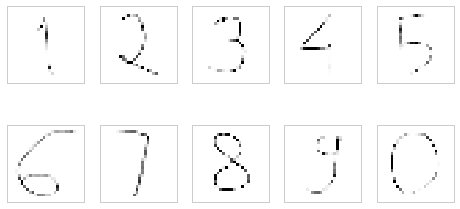

In [115]:
plt.rcParams["figure.figsize"] = [8,4]
for i in range(1,11):
    plt.subplot(2, 5 , i)
    plt.imshow(test_data[i-1, :, :])
    plt.xticks([]), plt.yticks([])

In [116]:
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1) # Expanding Dimension as (image_row, image_column, channel)
test_data /= 255  # Getting input in range (0,1)

In [117]:
preds=model.predict(test_data)
preds=np.argmax(preds,axis=1)

In [118]:
preds

array([1, 2, 3, 4, 5, 5, 1, 2, 3, 0], dtype=int64)

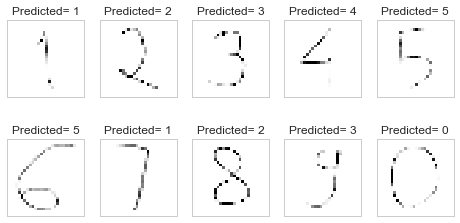

In [119]:
plt.rcParams["figure.figsize"] = [8,4]
for i in range(1,11):
    plt.subplot(2, 5 , i)
    plt.imshow(test_data_original[i-1, :, :]),plt.title("Predicted= "+str(preds[i-1]))
    plt.xticks([]), plt.yticks([])